In [1]:
import numpy as np
import pandas as pd
import pydeck as pdk
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from geopy.distance import geodesic
import xarray as xr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from astral.sun import sun
from astral.location import Observer
from datetime import datetime, timedelta
from scipy.spatial import cKDTree
import pytz
import random
import math
import pickle
from pyEDM import *
import json
from pyproj import Proj
from pyhdf.SD import SD, SDC

## Load Data

In [2]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

## Define Functions

In [3]:
def calculate_grid_window(res_km, target_area_km2=729, valid_fraction=1/3):
    """
    Calculate the size of an n x n satellite pixel grid that best approximates a target spatial area, 
    and determine the minimum number of valid pixels required within that grid based on a valid fraction.
    """
    
    # Calculate the ideal grid size (in pixels) to match the target spatial area
    ideal_grid_size = math.sqrt(target_area_km2 / (res_km ** 2))
    
    # Round ideal size to nearest integer to get base grid size
    base_grid_size = round(ideal_grid_size)
    
    # Find nearest odd integer grid sizes: one just below or equal, and one just above
    odd_floor = base_grid_size if base_grid_size % 2 == 1 else base_grid_size - 1
    odd_ceil = odd_floor + 2  # Next odd number above odd_floor
    
    # Compute the actual spatial areas these two grid sizes represent
    area_floor = (odd_floor * res_km) ** 2
    area_ceil = (odd_ceil * res_km) ** 2
    
    # Choose the odd grid size with the area closest to the target area
    if abs(area_floor - target_area_km2) <= abs(area_ceil - target_area_km2):
        n = odd_floor
    else:
        n = odd_ceil
    
    # Calculate total number of pixels in the grid window
    total_pixels = n ** 2
    
    # Calculate the minimum number of valid pixels required, rounding to nearest integer
    min_valid_pixels = int(valid_fraction * total_pixels + 0.5)
    
    return n, min_valid_pixels

/var/folders/2l/rp17r8915p798zn96xv29vqm0000gp/T/ipykernel_56610/3068363941.py:82: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = plt.pcolormesh(lon_grid, lat_grid, chl_data,


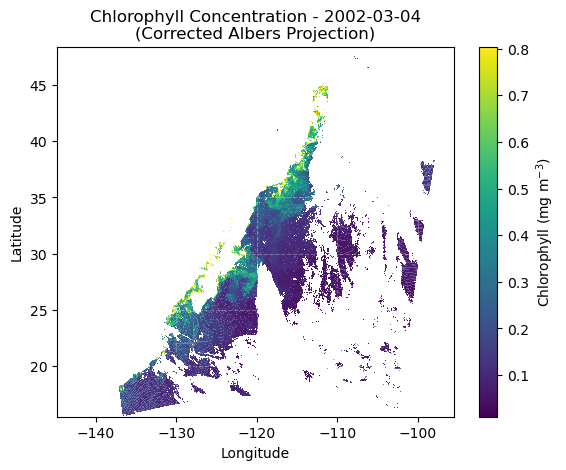

In [4]:
def get_projection_params(hdf_obj):
    """Extracts projection parameters from HDF attributes."""
    attr = hdf_obj.attributes()
    affine = attr['et_affine']
    return {
        'lat_0': attr['center_lat'],
        'lon_0': attr['center_lon'],
        'x_scale': affine[0],
        'y_scale': affine[3],
        'x_center_px': affine[4],
        'y_center_px': affine[5],
        'nrows': hdf_obj.select(list(hdf_obj.datasets().keys())[0]).dimensions()['fakeDim0'],
        'ncols': hdf_obj.select(list(hdf_obj.datasets().keys())[0]).dimensions()['fakeDim1']
    }

def load_chl_day(filename):
    """Loads HDF, applies scaling, and returns data + projection info."""
    hdf = SD(f'../data/chl_data/{filename}', SDC.READ)
    
    # Identify the primary dataset (usually the first one)
    sds_name = list(hdf.datasets().keys())[0]
    sds = hdf.select(sds_name)
    data = sds[:].astype(np.float32)
    
    # Get scaling attributes
    attrs = sds.attributes()
    slope = attrs.get('Slope', 1.0)
    intercept = attrs.get('Intercept', 0.0)
    base = attrs.get('Base', 10.0)
    
    # Apply transformation: base ** (slope * data + intercept)
    # Masking out land/fill values (usually -1 or 255) to avoid math errors
    invalid = (data < 0) | (data == 255)
    chl = np.full(data.shape, np.nan)
    chl[~invalid] = base ** (slope * data[~invalid] + intercept)
    
    # Extra safety: your specific NaN constant check
    #chl[np.isclose(chl, 0.009660507)] = np.nan
    
    # Extract projection info for coordinate building
    proj_info = get_projection_params(hdf)
    
    return chl, proj_info

def create_coordinate_grids(p_info):
    """Creates true Lat/Lon 2D grids for an Albers projection."""
    # 1. Setup projection
    p = Proj(proj='aea', lat_0=p_info['lat_0'], lon_0=p_info['lon_0'], 
             lat_1=30, lat_2=40, ellps='WGS84')
    
    # 2. Create pixel arrays
    cols = np.arange(p_info['ncols'])
    rows = np.arange(p_info['nrows'])
    col_grid, row_grid = np.meshgrid(cols, rows)
    
    # 3. Convert pixel indices back to meters using affine center
    # x_met = cx_met + (col - x_center_px) * scale * 1000
    cx_met, cy_met = p(p_info['lon_0'], p_info['lat_0'])
    
    x_met = cx_met + (col_grid - p_info['x_center_px']) * p_info['x_scale'] * 1000
    y_met = cy_met - (row_grid - p_info['y_center_px']) * p_info['y_scale'] * 1000
    
    # 4. Transform back to Lat/Lon
    lon_2d, lat_2d = p(x_met, y_met, inverse=True)
    return lat_2d, lon_2d

# --- Execution ---

with open('../data/chl_index.json', 'r') as f:
    chl_index = json.load(f)

date = '2002-03-04' # Using your example file date
if date in chl_index:
    chl_data, p_info = load_chl_day(chl_index[date])
    lat_grid, lon_grid = create_coordinate_grids(p_info)

    # --- Plot ---
    plt.figure()
    
    # 1. Use shading='nearest' to avoid the edge-calculation warning
    # 2. Add an alpha or background color to see where the data is
    mesh = plt.pcolormesh(lon_grid, lat_grid, chl_data, 
                          shading='nearest', 
                          cmap='viridis',
                          antialiased=True)
    
    plt.colorbar(mesh, label='Chlorophyll (mg m$^{-3}$)')
    
    # Add some gridlines to see the curvature
    plt.grid(color='white', linestyle='--', alpha=0.3)
    
    plt.title(f'Chlorophyll Concentration - {date}\n(Corrected Albers Projection)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [ ]:
hdf = SD("../data/chl_data/S1999351_chl_mapped.hdf", SDC.READ)
attr = hdf.attributes()
print(attr)
# # Look for these specific keys
# print(f"North: {attr.get('Northernmost Lat')}")
# print(f"South: {attr.get('Southernmost Lat')}")
# print(f"West:  {attr.get('Westernmost Lon')}")
# print(f"East:  {attr.get('Easternmost Lon')}")

In [ ]:
def get_sat_values(i, npp, chl_index, grid_size, ds_lats, ds_lons, lag=0, particle_tracking=False, max_day_offset=3, min_valid_pixels=1):
    # 1. Get the NPP observation details
    row = npp.loc[i]
    lat, lon = row['Latitude'], row['Longitude']
    orig_date = pd.to_datetime(row['Date'])

    # Find nearest satellite grid indices (for the window)
    nearest_lat_idx = np.abs(ds_lats - lat).argmin()
    nearest_lon_idx = np.abs(ds_lons - lon).argmin()

    half_window = grid_size // 2
    
    # 3. Search day offsets (0, then ±1, ±2, up to max_day_offset)
    for offset in range(max_day_offset + 1):
        for direction in [-1, 1] if offset > 0 else [0]:
            current_offset = lag + (direction * offset)
            target_date = orig_date + pd.Timedelta(days=current_offset)
            date_str = target_date.strftime('%Y-%m-%d')

            # Check if this date exists in our HDF index
            if date_str in chl_index:
                # Load the full day's data
                chl_full_day = load_chl_day(date_str, chl_index[date_str])
                
                # Define window slices
                lat_start = max(nearest_lat_idx - half_window, 0)
                lat_end = min(nearest_lat_idx + half_window + 1, len(ds_lats))
                lon_start = max(nearest_lon_idx - half_window, 0)
                lon_end = min(nearest_lon_idx + half_window + 1, len(ds_lons))

                # Handle Windowing
                if particle_tracking:
                    # Create pixel_df for particle tracking
                    lat_vals = ds_lats[lat_start:lat_end]
                    lon_vals = ds_lons[lon_start:lon_end]
                    lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
                    pixel_df = pd.DataFrame({'lat': lat_grid.ravel(), 'lon': lon_grid.ravel()})
                    
                    tracked_lats, tracked_lons = get_particle_tracked_positions(
                        orig_date, current_offset, pixel_df, ds_lats, ds_lons
                    )
                    
                    # Map tracked lat/lons back to array indices
                    # This assumes your tracking returns values that exist within ds_lats/lons
                    t_lat_idxs = [np.abs(ds_lats - tl).argmin() for tl in tracked_lats]
                    t_lon_idxs = [np.abs(ds_lons - tlo).argmin() for tlo in tracked_lons]
                    
                    # Extract values using advanced indexing
                    values = chl_full_day[t_lat_idxs, t_lon_idxs].reshape((grid_size, grid_size))
                else:
                    # Simple spatial slice
                    values = chl_full_day[lat_start:lat_end, lon_start:lon_end]
                    
                # Check for validity
                valid_count = np.isfinite(values).sum()
                if valid_count >= min_valid_pixels:
                    return i, values, current_offset

    return i, None, None

# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

# Calcualte grid size and min_valid_pixels for satellite data
res_km = 4
grid_size, min_valid_pixels = calculate_grid_window(res_km)

# Add satellite data to the NPP dataframe
input_vars = ['CHL'] #list(satellite_ds.data_vars)

# Precompute satellite latitude and longitude values
hdf_file = "../data/chl_data/S1999351_chl_mapped.hdf"
hdf = SD(hdf_file, SDC.READ)
sds_name = list(hdf.datasets().keys())[0]  # 'chl_1997335_1997365'
sds = hdf.select(sds_name)
chl_data = sds[:]  # shape (3405, 3840)
nrows, ncols = chl_data.shape
min_lat, max_lat = 16, 45
min_lon, max_lon = -135, -100

lats = np.linspace(max_lat, min_lat, nrows)
lons = np.linspace(min_lon, max_lon, ncols)
lon_grid, lat_grid = np.meshgrid(lons, lats)

lags = [0] #[-28, -21, -14, -7, 0, 7, 14, 21, 28]
particle_tracking = False

total_iterations = len(input_vars) * len(lags)
# with tqdm(total=total_iterations) as pbar:
for var in input_vars:
    for lag in lags:
        print(var, lag)
        npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']].copy()
        col_values = f'{var}_values_lag_{lag}'
        col_offset = f'{var}_offset_days_lag_{lag}'
        npp[col_values] = None
        npp[col_offset] = None

        results = Parallel(n_jobs=-1)(
            delayed(get_sat_values)(
                i, npp, chl_index, grid_size, lat_grid, lon_grid, lag, particle_tracking
            ) for i in range(len(npp))
        )
        
        # Add results to NPP dataframe
        for result in results:
            if result is not None:
                i, window, offset = result

                if window is not None:
                    if 'depth' in window.coords:
                        window = window.drop_vars('depth')
                    if 'depth' in window.dims:
                        window = window.squeeze(dim='depth')
                    window = window.astype('float32')
                
                npp.at[i, col_values] = window
                npp.at[i, col_offset] = offset

            # # Save individual columns immediately after computation
            # if particle_tracking == True:
            #     save_folder_name = f'npp_columns/{var}_lag_{lag}.pkl'
            # else:
            #     save_folder_name = f'npp_columns_no_particle_tracking/{var}_lag_{lag}.pkl'
            # with open(save_folder_name, 'wb') as f:
            #     pickle.dump({
            #         col_values: npp[col_values],
            #         col_offset: npp[col_offset]
            #     }, f)
                
            # pbar.update(1)

In [ ]:
# Pick one index from your NPP dataframe
i = 0 
target_lat = npp.loc[i, 'Latitude']
target_lon = npp.loc[i, 'Longitude']

# Find the indices
lat_idx = np.abs(lats - target_lat).argmin()
lon_idx = np.abs(lons - target_lon).argmin()

print(f"Target: {target_lat}, {target_lon}")
print(f"Closest Grid Point: {lats[lat_idx]}, {lons[lon_idx]}")
print(f"Array Indices: [{lat_idx}, {lon_idx}]")

# Check the actual data around that point
window = chl_data[lat_idx-2:lat_idx+3, lon_idx-2:lon_idx+3]
print("5x5 Data Window:")
print(window)

In [ ]:
# Extract values from nxn satellite window
def get_sat_values(i, npp, ds, var, grid_size, ds_lats, ds_lons, ds_times, lag=0, particle_tracking=True, max_day_offset=3):
    '''
    npp: net primary production data
    ds: satellite data
    var: data variable
    '''

    # Get the NPP observation
    row = npp.loc[i]
    date, lat, lon = row['Date'], row['Latitude'], row['Longitude']
    orig_date = pd.to_datetime(date)
    
    # Lag date if necessary
    date = orig_date + pd.Timedelta(days=lag)
    
    # Find nearest satellite grid point
    nearest_lat_idx = np.abs(ds_lats - lat).argmin()
    nearest_lon_idx = np.abs(ds_lons - lon).argmin()

    # Define nxn window indices
    half_window = grid_size // 2
    lat_slice = slice(max(nearest_lat_idx - half_window, 0), min(nearest_lat_idx + half_window + 1, len(ds_lats)))
    lon_slice = slice(max(nearest_lon_idx - half_window, 0), min(nearest_lon_idx + half_window + 1, len(ds_lons)))

    # Get dataframe of (lat, lon) pairs for satellite grid
    lat_vals = ds.latitude[lat_slice].values
    lon_vals = ds.longitude[lon_slice].values
    lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
    pixel_df = pd.DataFrame({'lat': lat_grid.ravel(),'lon': lon_grid.ravel()})

    # Find index of closest satellite date
    if np.abs(ds_times - date).min() <= pd.Timedelta(days=max_day_offset):      # Check if there is satellite data within max_day_offset
        time_idx = np.abs(ds_times - date).argmin()

        # Search day offsets
        for offset in range(max_day_offset + 1):
            for direction in [-1, 1] if offset > 0 else[0]:  # do offset 0 first, then ±1, ±2...
                t_idx = time_idx + direction * offset
                if not (0 <= t_idx < len(ds_times)):
                    continue
                sat_day = ds_times[t_idx]
                # Get particle tracked positions if specified
                if particle_tracking == True:
                    tracked_lats, tracked_lons = get_particle_tracked_positions(orig_date, lag + (direction * offset), pixel_df, ds_lats, ds_lons)
                else:
                    tracked_lats = lat_grid.ravel()
                    tracked_lons = lon_grid.ravel()
                window = ds[var].sel(time=sat_day).sel(latitude=xr.DataArray(tracked_lats, dims="points"),
                                                       longitude=xr.DataArray(tracked_lons, dims="points"))
                values = window.values.reshape((grid_size, grid_size))
                valid_count = np.isfinite(values).sum()
                if valid_count >= min_valid_pixels:
                    return i, window, direction * offset

    # If no valid window found
    return i, None, None

def get_day_length(row):
    try:
        date = pd.to_datetime(row['Date']).date()
        observer = Observer(latitude=row['Latitude'], longitude=row['Longitude'])
        s = sun(observer, date=date)

        # Convert UTC times to local timezone (e.g., US/Pacific)
        local_tz = pytz.timezone('US/Pacific')

        sunrise_local = s['sunrise'].astimezone(local_tz)
        sunset_local = s['sunset'].astimezone(local_tz)

        if sunset_local < sunrise_local:
            sunset_local += timedelta(days=1)

        # Calculate day length in hours
        day_length_hours = (sunset_local - sunrise_local).total_seconds() / 3600

        return day_length_hours
        
    except Exception as e:
        return None

def run_get_sat_values(i, npp, satellite_data, var, grid_size, ds_lats, ds_lons, ds_times, lag, particle_tracking):
    try:
        window, offset = get_sat_values(i, npp, satellite_data, var, grid_size, ds_lats, ds_lons, ds_times, lag, particle_tracking)
        return i, window, offset
    except:
        return i, None, None

## Create input DataFrame (no lags yet)

In [ ]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

# Calculate grid size and min_valid_pixels for satellite data
res_km = 4
grid_size, min_valid_pixels = calculate_grid_window(res_km)

In [ ]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

# Calcualte grid size and min_valid_pixels for satellite data
res_km = 4
grid_size, min_valid_pixels = calculate_grid_window(res_km)

# Add satellite data to the NPP dataframe
input_vars = ['RRS412', 'RRS443', 'RRS490', 'RRS555', 'RRS670', 'ZSD'] #list(satellite_ds.data_vars)
satellite_data = satellite_ds[input_vars].copy()

# Precompute satellite latitude and longitude values
ds_lats = satellite_ds.latitude.values
ds_lons = satellite_ds.longitude.values
ds_times = pd.to_datetime(satellite_ds.time.values)

lags = [-14, -7, 0, 7, 14] #[-28, -21, -14, -7, 0, 7, 14, 21, 28]
particle_tracking = True

total_iterations = len(input_vars) * len(lags)
with tqdm(total=total_iterations) as pbar:
    for var in input_vars:
        for lag in lags:
            npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']].copy()
            col_values = f'{var}_values_lag_{lag}'
            col_offset = f'{var}_offset_days_lag_{lag}'
            npp[col_values] = None
            npp[col_offset] = None

            # Run NPP observations in parallel
            results = Parallel(n_jobs=-1)(
                delayed(run_get_sat_values)(
                    i, npp, satellite_data, var, grid_size, ds_lats, ds_lons, ds_times, lag, particle_tracking
                ) for i in range(len(npp))
            )

            # Add results to NPP dataframe
            for result in results:
                if result is not None:
                    i, window, offset = result

                    if window is not None:
                        if 'depth' in window.coords:
                            window = window.drop_vars('depth')
                        if 'depth' in window.dims:
                            window = window.squeeze(dim='depth')
                        window = window.astype('float32')
                    
                    npp.at[i, col_values] = window
                    npp.at[i, col_offset] = offset


            # Save individual columns immediately after computation
            if particle_tracking == True:
                save_folder_name = f'npp_columns/{var}_lag_{lag}.pkl'
            else:
                save_folder_name = f'npp_columns_no_particle_tracking/{var}_lag_{lag}.pkl'
            with open(save_folder_name, 'wb') as f:
                pickle.dump({
                    col_values: npp[col_values],
                    col_offset: npp[col_offset]
                }, f)
                
            pbar.update(1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC

# --- Open your HDF file ---
#hdf_file = "/Users/deliacarpenter/Desktop/Research/primary-productivity/data/chl_data/C2000001_chl_comp.hdf"
hdf_file = "/Users/deliacarpenter/Desktop/Research/primary-productivity/data/chl_data/S1999351_chl_mapped.hdf"
hdf = SD(hdf_file, SDC.READ)

# --- Select dataset ---
sds_name = list(hdf.datasets().keys())[0]  # 'chl_1997335_1997365'
sds = hdf.select(sds_name)
chl_data = sds[:]  # shape (3405, 3840)

# --- Handle fill values ---
fill_value = sds.attributes()['_FillValue']
chl_data = chl_data.astype(np.float32)
chl_data[chl_data == fill_value] = np.nan  # mask missing values

# --- Apply scaling (from attributes) ---
slope = sds.attributes()['Slope']
intercept = sds.attributes()['Intercept']
base = sds.attributes()['Base']

# Original equation: Base ** (Slope * data + Intercept)
chl_data_scaled = base ** (slope * chl_data + intercept)

# --- Approximate lat/lon grid ---
nrows, ncols = chl_data.shape
min_lat, max_lat = 16, 45
min_lon, max_lon = -135, -100

lats = np.linspace(max_lat, min_lat, nrows)
lons = np.linspace(min_lon, max_lon, ncols)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# --- Plot ---
plt.figure()
plt.pcolormesh(lon_grid, lat_grid, chl_data_scaled, shading='auto', cmap='viridis')
plt.colorbar(label='Chlorophyll (mg m^-3)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{hdf_file.split('chl_data/')[1]}')
plt.show()

In [ ]:
chl_data_scaled

In [ ]:
# --- Approximate lat/lon grid ---
nrows, ncols = chl_data.shape
min_lat, max_lat = 16, 45
min_lon, max_lon = -135, -100

lats = np.linspace(max_lat, min_lat, nrows)
lons = np.linspace(min_lon, max_lon, ncols)
lon_grid, lat_grid = np.meshgrid(lons, lats)
lat_grid